In [1]:
import os
from pathlib import Path

In [2]:
# Change working path to the directory of this script
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS')

In [3]:
imageFilePath = Path('/Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf')

In [4]:
dataFile = open(imageFilePath, 'rb')
dataSig = list(dataFile.read(8))

In [5]:
# Assert inputted data has Philips signature
assert dataSig == [0,0,0,0,255,255,0,0]
assert imageFilePath.suffix == '.rf'

In [6]:
destImgFilePath = Path(imageFilePath.__str__().replace('.rf', '.mat'))

In [27]:
from src.Parsers.philipsRfParser import philipsRfParser

imgShape = philipsRfParser(imageFilePath.__str__(), txBeamperFrame=90)

Opening: /Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:21.653657 seconds.
Parsing header info ...
Elapsed time is 0:00:21.836684 seconds.
Parsing RF data ...
Elapsed time is 0:00:33.903930 seconds.
Organizing based on data type ...
	PostAGNOS
		Capture_ML:	16x

		Echo_ML:	2x

Elapsed time is 0:00:38.875892 seconds.
Done


In [28]:
imgShape

(4, 5, 2703, 180)

In [7]:
from src.Parsers.philipsMatParser import getImage as philipsMatParser

imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = philipsMatParser(destImgFilePath, destImgFilePath, frame=0)

/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/src/Parsers/philipsMatParser.py:113: RuntimeWarning: divide by zero encountered in log10
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore


In [8]:
from pyQus.analysisObjects import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [9]:
from pyQus.spectral import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
# spectralAnalysis.config = config
# spectralAnalysis.initAnalysisConfig()
# spectralAnalysis.scSplineX = scSplineX
# spectralAnalysis.scSplineY = scSplineY

In [10]:
from pyQus import spectral
from src.DataLayer.spectral import SpectralData, ScConfig

scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [11]:
spectralData.convertImagesToRGB()

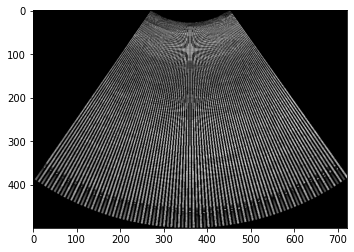

In [12]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.scBmode)